In [ ]:
#! kaggle datasets download uraninjo/augmented-alzheimer-mri-datasetm

###https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

In [ ]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2023-08-11 08:36:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-11 08:36:14 (104 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



#  Uploading the Data

In [ ]:
########### splitting data ############
%pip install split-folders
import splitfolders
splitfolders.ratio('..///content/drive/MyDrive/ResnetDataset/AugmentedDataSet', output="input", seed=1345, ratio=(0.7,0.3,0))

SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
data_dir = '..///content/input'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

Copying files: 34004 files [01:34, 358.23 files/s]


**Mathematical model for Hyper param tuning**

In [ ]:
import numpy as np
from scipy.optimize import minimize
# Objective Function
def objective_function(params, target_accuracy):
    epochs, iterations, batch_size, dropout_factor = params
    return -target_accuracy / (epochs * iterations * batch_size * (1 - dropout_factor))
# Example optimization
def optimize_params(target_accuracy, input_size):
    # Bounds for each parameter: (epochs, iterations, batch_size, dropout_factor)
    bounds = [(1, 100), (1, 1000), (1, 128), (0.0, 0.99)]
    # Initial guess for the parameters: (epochs, iterations, batch_size, dropout_factor)
    initial_guess = [10, 100, 64, 0.1]
    # Perform optimization using scipy's minimize function
    result = minimize(objective_function, initial_guess, args=(target_accuracy,),
                      bounds=bounds, method='SLSQP')
    # Get the optimized parameters
    epochs, iterations, batch_size, dropout_factor = result.x

    return epochs, iterations, batch_size, dropout_factor
if __name__ == "__main__":
    # Example input size and target accuracy
    input_size = 34004
    target_accuracy = 0.99
    # Optimize parameters
    epochs, iterations, batch_size, dropout_factor = optimize_params(target_accuracy, input_size)
    print("Optimized Parameters:")
    print(f"Number of Epochs: {int(epochs)}")
    print(f"Number of Iterations per Epoch: {int(iterations)}")
    print(f"Batch Size: {int(batch_size)}")
    print(f"Dropout Factor: {dropout_factor:.2f}")


Optimized Parameters:
Number of Epochs: 10
Number of Iterations per Epoch: 100
Batch Size: 64
Dropout Factor: 0.10


# Defining Categories

In [ ]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

### Calculating the number of images in each category in training data

In [ ]:
for category in CATEGORIES:
  print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

MildDemented 6286 images
ModerateDemented 4524 images
NonDemented 6720 images
VeryMildDemented 6272 images


# Creating Train and Validation DataFrame

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(23802, 3)

In [ ]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=4) ###### train size from 0.2 to 0.3

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [ ]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(16661, 3)
(7141, 3)


In [ ]:
train.head()

,file,category,category_id
0,train/ModerateDemented/08d6e220-dff0-4573-a021...,ModerateDemented,1
1,train/MildDemented/096ff2f7-0ac9-4954-822d-1e0...,MildDemented,0
2,train/NonDemented/3d6e0205-b832-492e-a3ff-f97e...,NonDemented,2
3,train/MildDemented/96e9db22-d612-4200-bb6c-0cb...,MildDemented,0
4,train/NonDemented/919e239c-0c3d-434a-9ab5-d75e...,NonDemented,2


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['category_id'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['category_id'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['file'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_3, *['category'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_4, *['file', 'category'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_5, *['category_id', 'file'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_6, *['category_id', 'category'], **{'inner': 'stick'})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
validation.head()

,file,category,category_id
0,train/VeryMildDemented/ef7ba003-104f-4430-a7e9...,VeryMildDemented,3
1,train/ModerateDemented/d325411c-9c6c-45ac-97ea...,ModerateDemented,1
2,train/ModerateDemented/7db07ebe-6c33-4608-89e5...,ModerateDemented,1
3,train/ModerateDemented/6e40bec3-1a44-4cfa-ade7...,ModerateDemented,1
4,train/ModerateDemented/d7a391bd-1253-48f0-bbec...,ModerateDemented,1


# Creating Test DataFrame

In [ ]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(10201, 3)

# Demonstrating Example Images

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

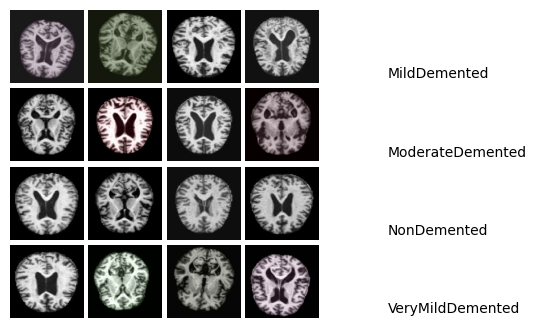

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# Keras ImageDataGenerator

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 16661 validated image filenames belonging to 4 classes.
Found 7141 validated image filenames belonging to 4 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 10201 validated image filenames belonging to 4 classes.


## Early Stopping

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

###Creating CallBacks   ===> 8-8-2023

In [ ]:
# Hyperparameter Tuning ===>   8-8-2023

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Creating Model based on ResNet152V2

In [ ]:
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer = tf.keras.optimizers.RMSprop()
    #res_model.compile(loss='categorical_crossentropy', optimizer='ٌadam', metrics=['accuracy'])
    res_model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return res_model

In [ ]:
res_model = create_model()

In [ ]:
res_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Model Architecture Visualization
tf.keras.utils.plot_model(res_model, to_file='resnet152v2.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

# Training the Model

In [ ]:
history = res_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=callbacks,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
521/521 [==============================] - 220s 296ms/step - loss: 0.8426 - accuracy: 0.6095 - val_loss: 1.6436 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 2/50
521/521 [==============================] - 150s 288ms/step - loss: 0.5002 - accuracy: 0.7833 - val_loss: 0.4315 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 3/50
521/521 [==============================] - 149s 286ms/step - loss: 0.3493 - accuracy: 0.8607 - val_loss: 0.4567 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/50
521/521 [==============================] - 146s 281ms/step - loss: 0.2462 - accuracy: 0.9103 - val_loss: 0.4354 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 5/50
521/521 [==============================] - 151s 289ms/step - loss: 0.1831 - accuracy: 0.9348 - val_loss: 0.3137 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 6/50
521/521 [==============================] - 147s 282ms/step - loss: 0.1477 - accuracy: 0.9509 - val_loss: 0.4947 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 7/50
521/521 [==========================

# Plotting the history of model

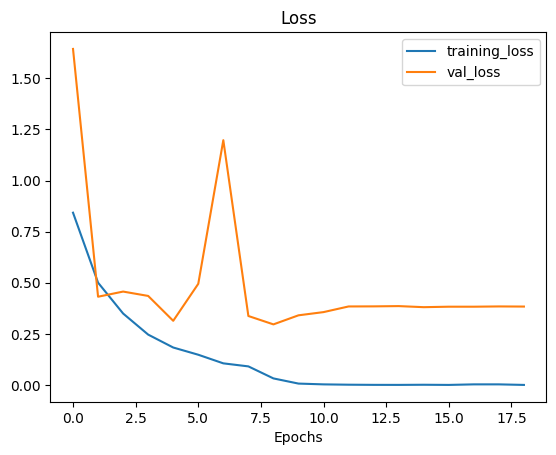

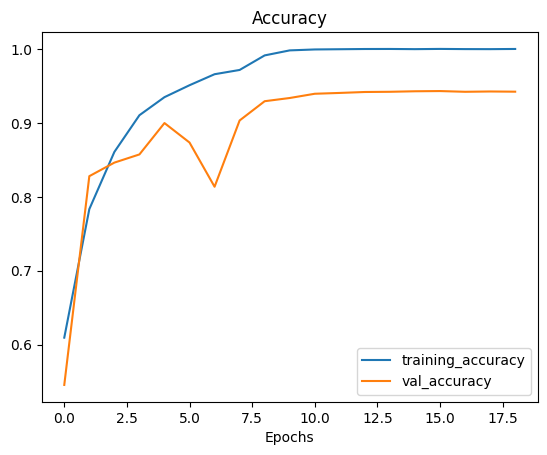

In [ ]:
plot_loss_curves(history)

# Evaluation

In [ ]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

224/224 [==============================] - 19s 85ms/step - loss: 0.2962 - accuracy: 0.9293

Train loss: 0.30
Train Accuracy: 92.93 %


In [ ]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

319/319 [==============================] - 28s 86ms/step - loss: 0.3078 - accuracy: 0.9279

Test loss: 0.31 
Test Accuracy: 92.79 %


In [ ]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

319/319 [==============================] - 28s 81ms/step


,precision,recall,f1-score,support
MildDemented,0.976200,0.913512,0.943816,2694.00000
ModerateDemented,0.998968,0.998453,0.998710,1939.00000
NonDemented,0.933480,0.881944,0.906981,2880.00000
VeryMildDemented,0.836809,0.940476,0.885619,2688.00000
accuracy,0.927850,0.927850,0.927850,0.92785
macro avg,0.936364,0.933596,0.933782,10201.00000
weighted avg,0.931737,0.927850,0.928516,10201.00000


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['precision', 'recall'], ['recall', 'f1-score'], ['f1-score', 'support']]], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_7, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_8, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_9, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_10, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_11, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_12, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_13, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_14, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_15, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_16, *[[['precision', 'recall'], ['recall', 'f1-score'], ['f1-score', 'support']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_17, *['precision', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_18, *['recall', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_19, *['f1-score', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_20, *['support', 'index'], **{'inner': 'stick'})
chart

####Create the Confusion Matrix

319/319 [==============================] - 29s 91ms/step
Confusion Matrix:
[[2461    2   56  175]
 [   2 1936    0    1]
 [  23    0 2540  317]
 [  35    0  125 2528]]


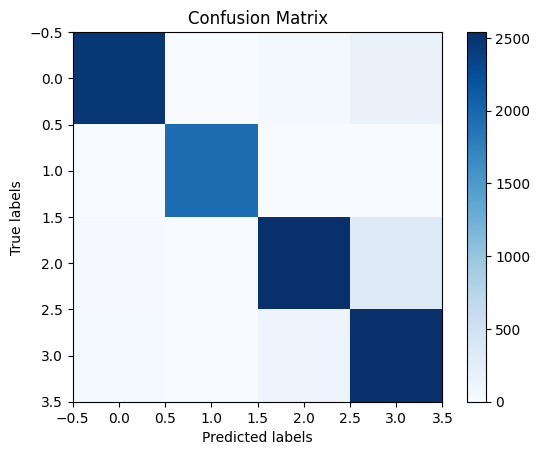

In [ ]:
from sklearn.metrics import confusion_matrix
# Set the number of classes for your task
num_classes = 4

# Generate predictions on the test dataset
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


In [ ]:
# Evaluate the Model on Test Data   ======>9-8-2023
test_loss, test_accuracy = res_model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


319/319 [==============================] - 28s 86ms/step - loss: 0.3078 - accuracy: 0.9279
Test Loss: 0.30783820152282715
Test Accuracy: 0.9278501868247986


In [ ]:
# Evaluate the Model on Train Data   ======>9-8-2023
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

224/224 [==============================] - 19s 85ms/step - loss: 0.2962 - accuracy: 0.9293

Train loss: 0.30
Train Accuracy: 92.93 %


"\n# Compute and Plot ROC Curves\ny_true = test_generator.classes\ny_pred = res_model.predict(test_generator)\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(4):\n    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.subplot(1, 2, 2)\nplt.plot([0, 1], [0, 1], 'k--')\nfor i in range(4):\n    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curves')\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n"

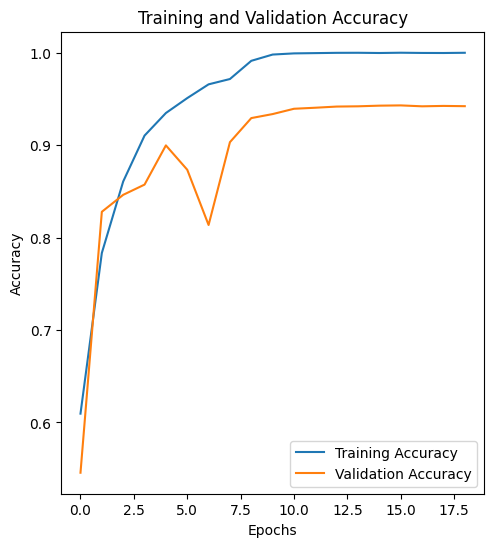

In [ ]:
# Metrics Visualization    =====>9-8-2023
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
'''
# Compute and Plot ROC Curves
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.show()
'''

In [ ]:
res_model.save('Resnet_model.h5')

In [ ]:
!zip -r dowinloadme.zip Resnet_model.h5

updating: Resnet_model.h5 (deflated 10%)


In [3]:
import numpy as np
import random

# Define the input parameters
N = 10000  # Dataset size (Number of samples in the dataset)
Acc = 0.95  # Target accuracy (e.g., 0.95 for 95% accuracy)

# Define the search space
EPOCH_MIN = 10
EPOCH_MAX = 200
BATCH_SIZE_LIST = [32, 64, 128, 256]
DROPOUT_MIN = 0.0
DROPOUT_MAX = 0.5
NUM_ITERATIONS = 50  # Number of random search iterations

# Objective function
def objective_function(epochs, batch_size, dropout_factor, Acc):
    # Avoid division by zero (when dropout factor is 1)
    if dropout_factor >= 1:
        dropout_factor = 0.99
    return Acc / (epochs * batch_size * (1 - dropout_factor))

# Define heuristic relationships
def get_epochs(N):
    # Assume linear relation between dataset size and number of epochs
    return random.randint(EPOCH_MIN, EPOCH_MAX)

def get_batch_size(N):
    # Assume inverse square root relationship between dataset size and batch size
    return random.choice(BATCH_SIZE_LIST)

def get_dropout_factor(Acc):
    # Assume dropout factor is related to target accuracy
    # Higher accuracy requires lower dropout (just for simplicity)
    return random.uniform(DROPOUT_MIN, DROPOUT_MAX * (1 - Acc))

# Random search heuristic to optimize hyperparameters
def hyperparameter_search(N, Acc, iterations):
    best_f = -np.inf  # Initialize with a very low value
    best_params = None

    for i in range(iterations):
        # Generate random hyperparameters based on heuristic rules
        epochs = get_epochs(N)
        batch_size = get_batch_size(N)
        dropout_factor = get_dropout_factor(Acc)

        # Evaluate the objective function
        f_value = objective_function(epochs, batch_size, dropout_factor, Acc)

        # Track the best solution found so far
        if f_value > best_f:
            best_f = f_value
            best_params = (epochs, batch_size, dropout_factor)

        print(f"Iteration {i+1}/{iterations}: En={epochs}, Bs={batch_size}, Df={dropout_factor:.2f}, Objective={f_value:.6f}")

    return best_params, best_f

# Run the optimization search
best_params, best_f = hyperparameter_search(N, Acc, NUM_ITERATIONS)

# Output the best found solution
print(f"\nBest Hyperparameters: Epochs = {best_params[0]}, Batch Size = {best_params[1]}, Dropout Factor = {best_params[2]:.2f}")
print(f"Best Objective Value: {best_f:.6f}")


Iteration 1/50: En=98, Bs=32, Df=0.02, Objective=0.000311
Iteration 2/50: En=114, Bs=64, Df=0.02, Objective=0.000133
Iteration 3/50: En=140, Bs=64, Df=0.00, Objective=0.000107
Iteration 4/50: En=112, Bs=256, Df=0.01, Objective=0.000033
Iteration 5/50: En=100, Bs=32, Df=0.02, Objective=0.000302
Iteration 6/50: En=186, Bs=128, Df=0.01, Objective=0.000040
Iteration 7/50: En=129, Bs=32, Df=0.02, Objective=0.000234
Iteration 8/50: En=13, Bs=128, Df=0.02, Objective=0.000581
Iteration 9/50: En=147, Bs=64, Df=0.01, Objective=0.000102
Iteration 10/50: En=186, Bs=32, Df=0.01, Objective=0.000161
Iteration 11/50: En=177, Bs=32, Df=0.01, Objective=0.000169
Iteration 12/50: En=48, Bs=128, Df=0.00, Objective=0.000155
Iteration 13/50: En=45, Bs=32, Df=0.01, Objective=0.000669
Iteration 14/50: En=106, Bs=64, Df=0.01, Objective=0.000141
Iteration 15/50: En=142, Bs=64, Df=0.00, Objective=0.000105
Iteration 16/50: En=139, Bs=32, Df=0.02, Objective=0.000219
Iteration 17/50: En=66, Bs=32, Df=0.01, Objective